
Notes are from Fandango, Armando. Mastering TensorFlow 1.x: Advanced machine learning and deep learning concepts using TensorFlow 1.x and Keras (Kindle Location 2809). Packt Publishing. Kindle Edition.

# RNN in TensorFlow Keras - TimeSeries Data <a class="tocSkip">

Building an RNN network in Keras is much simpler as compared to building using lower = level TensorFlow classes and methods.


In [1]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import sklearn as sk
from sklearn import preprocessing as skpp
print("sklearn:{}".format(sk.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20,
                     'figure.figsize': [15,10] 
                    }
                   )
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.losses import mean_squared_error as k_mse
from keras.backend import sqrt as k_sqrt
import keras.backend as K

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.5
Pandas:0.22.0
sklearn:0.19.1
Matplotlib:2.2.2
TensorFlow:1.11.0
Keras:2.2.4


Using TensorFlow backend.


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Read and pre-process the dataset

In [3]:
#filepath = os.path.join(datasetslib.datasets_root,
#                        'ts-data',
#                        'international-airline-passengers-cleaned.csv'
#                       ) 

filepath = '../data/international-airline-passengers.csv'
dataframe = pd.read_csv(filepath,
                        usecols=[1],
                        header=0)
dataset = dataframe.values
dataset = dataset.astype(np.float32)
dataset=dataset[:-1]


In [4]:
# normalize the dataset
scaler = skpp.MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test sets
train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)
n_x=1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=1)

# Keras SimpleRNN for TimeSeries Data

In [9]:
tf.reset_default_graph()
keras.backend.clear_session()

From here onwards, the preprocessing differs. 

For Keras, the input has to be in the shape (samples, time steps, features). 

As we converted our data to the supervised machine learning format, while reshaping the data, we can either set the time steps to 1, thus feeding all input time steps as features, or we can set the time steps to the actual number of time steps, thus feeding the feature set for each time step. 

In other words, the X_train and X_test datasets that we obtained earlier could be reshaped as one of the following methods: 

* Method 1 : n timesteps with 1 feature: X_train.reshape( X_train.shape[ 0], X_train.shape[ 1], 1) 

* Method 2 : 1 timestep with n features: X_train.reshape( X_train.shape[ 0], 1, X_train.shape[ 1])



Here we will shape the datasets with a feature size of 1 because we are using only one variable as input:

In [10]:

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)
print(X_train.shape,X_test.shape)

(95, 1, 1) (47, 1, 1)


In [11]:
# create and fit the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='mean_squared_error', optimizer='adam')



In [14]:
#As our dataset is small, we use a batch_size of 1 and train for 20 iterations, 
#but for larger datasets, you would need to tune the value of these and other hyper-parameters.

model.fit(X_train, Y_train, epochs=20, batch_size=1)

Epoch 1/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 2/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 4/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 5/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 7/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 8/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 9/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 10/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 11/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 12/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 13/20
95/95 [==============================

In [15]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)



In [16]:
# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

Train Score: 22.78 RMSE
Test Score: 51.47 RMSE


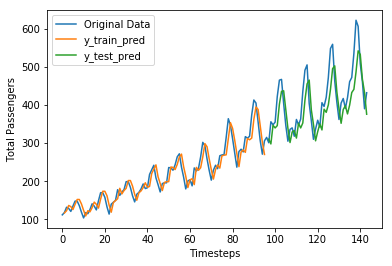

In [17]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset),:]=y_test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# Keras LSTM for TimeSeries Data

In [18]:
tf.reset_default_graph()
keras.backend.clear_session()


In [19]:
# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)


In [20]:
# create and fit the LSTM model
model = Sequential()
model.add(LSTM(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 [==============================] - 1s 12ms/step - loss: 0.0502
Epoch 2/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 3/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0190
Epoch 4/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 5/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 6/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 7/20
95/95 [==============================] - 0s 5ms/step -

Train Score: 32.09 RMSE
Test Score: 75.85 RMSE


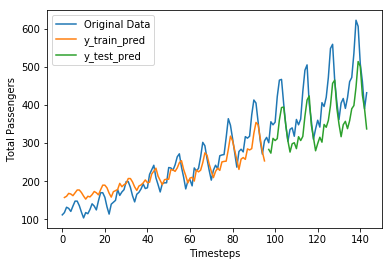

In [21]:


# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# Keras GRU for TimeSeries Data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 [==============================] - 1s 10ms/step - loss: 0.0257
Epoch 2/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 3/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 4/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 5/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 6/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 7/20
95/95 [==============================] - 0s 5ms/step - l

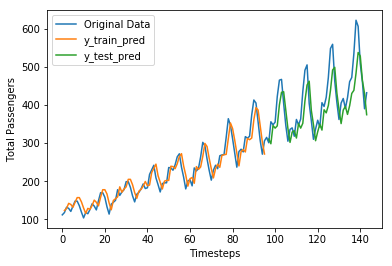

In [22]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# create and fit the GRU Model
model = Sequential()
model.add(GRU(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()